# Data Introduction
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.
[Data Source](https://archive.ics.uci.edu/ml/datasets/online+retail)

# Variables Information
This dataframe contains 8 variables that correspond to:
InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* **Description:** Product (item) name. Nominal.

* **Quantity:** The quantities of each product (item) per transaction. Numeric.

* **InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.

* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.

* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* **Country:** Country name. Nominal, the name of the country where each customer resides.

In [1]:
import pandas as pd
import numpy as np

from datetime import date
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

import re
import os
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from collections import Counter
import operator

# Load data

In [10]:
df = pd.read_csv('UK retailer E-commerce data.csv',encoding = "ISO-8859-1",converters={'CustomerID':str})
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     541909 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
# check how many null values in each attribute
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [14]:
df.shape # There are 541909 rows and 8 variables in the dataset

(541909, 8)

In [18]:
# get date attributes
df['Date'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m-%d'))    
df.Date = pd.to_datetime(df.Date)
df['Year_Month'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))   
df['day_of_week'] = df['InvoiceDate'].dt.weekday_name

# Exploratory Data Analysis 

In [94]:
print('Number of Customers: ',df['CustomerID'].nunique())
print('Number of Products:  ',df['StockCode'].nunique())

Number of Customers:  4373
Number of Products:   4070


## Order Frequency by Date
**From the plot, we can see that most of the orders were placed around the end of year. <br>
Since we have Thanks giving and Christmas in the end of year, most of the wholesalers stock their product before holidays <br> this could explain why most of orders were placed around the end of year.**

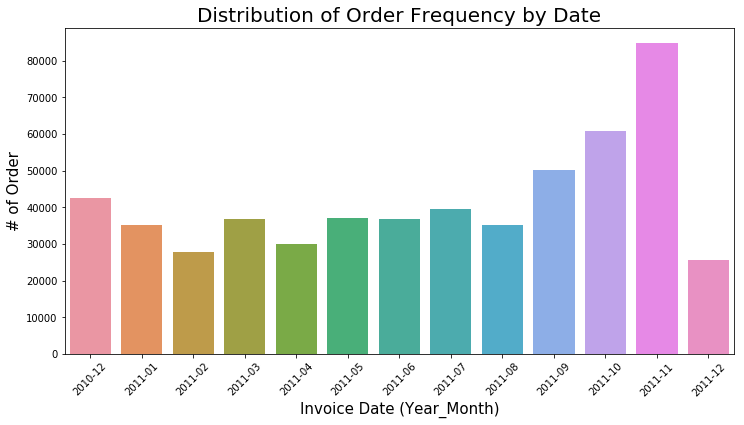

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='Year_Month', data=df)
plt.title('Distribution of Order Frequency by Date', fontsize=20)
plt.xlabel('Invoice Date (Year_Month)',fontsize=15)
plt.ylabel('# of Order',fontsize=15)
plt.xticks(rotation=45)
plt.show()

## Order Frequency by Day of Week
**From the bar plot, we can see that there are slightly higher purchase happening on Thursday. <br>
Interestingly, there was no purchase on Saturday at all.**

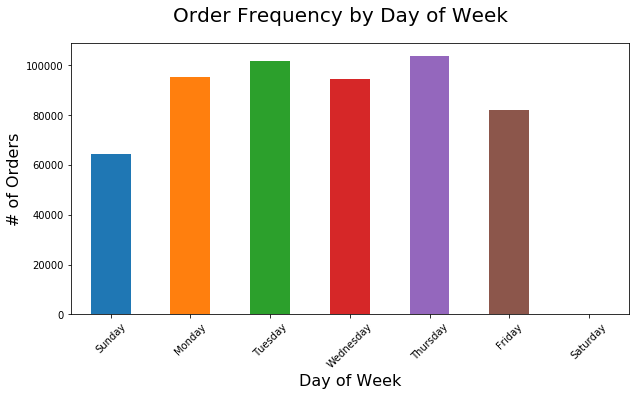

In [30]:
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=[ 'Sunday', 'Monday','Tuesday','Wednesday',
                                                                  'Thursday','Friday','Saturday'], ordered=True)
count = df['day_of_week'].value_counts()
count = count.sort_index()
plt.suptitle('Order Frequency by Day of Week', fontsize=20)

plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('# of Orders', fontsize=16)
count.plot(kind='bar',figsize=(10,5), rot='45')
plt.show()

## Order Frequency by Country (Create Choropleth Map using Plotly)
**From the map, it is clear that UK had most orders among 37 countries. <br>
Since this wholesaler is UK based, this finding is not surprising.**

In [48]:
con = df.groupby('Country')['InvoiceNo'].count().to_frame().reset_index().rename(columns={'InvoiceNo':'Total_Orders'})
con = con.drop([37])

In [49]:
con

,Country,Total_Orders
0,Australia,1259
1,Austria,401
2,Bahrain,19
3,Belgium,2069
4,Brazil,32
5,Canada,151
6,Channel Islands,758
7,Cyprus,622
8,Czech Republic,30
9,Denmark,389


In [53]:
init_notebook_mode(connected=True)

In [54]:
data = dict(type='choropleth',
locations = con['Country'],
locationmode = 'country names', z = con['Total_Orders'],
text = con['Country'], colorbar = {'title':'Total Orders'},
colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]], reversescale = True,
            marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ))

In [63]:
layout = dict(title='Order Frequency by Country',
geo = dict(showframe=False,projection={'type':'equirectangular'}))

In [64]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

**Since Github hasn't yet rendered iframes at the moment, plotly graphs do not show up on the page. <br>
I screenshot the plotly map result for demonstration purpose.**

<img src='map.png'>

## Which country's customers had highest average spending
**From the result, we can see that Customers had highest average spending. <br>
Although UK had largest number of customers, customers from UK had relatively lower average spending.**

In [ ]:
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

In [128]:
pri = round(df.groupby('Country')['Total_Price'].sum(),2).to_frame().reset_index()
pri = pri.drop([37])
con_pri = pd.merge(con, pri, how='left', on='Country')

In [132]:
con_pri['Average_Price'] = round(con_pri['Total_Price']/con_pri['Total_Orders'],2)

In [135]:
con_pri.sort_values(by=['Average_Price'], ascending=False)

,Country,Total_Orders,Total_Price,Average_Price
24,Netherlands,2371,284661.54,120.06
0,Australia,1259,137077.27,108.88
20,Japan,358,35340.62,98.72
32,Sweden,462,36595.91,79.21
9,Denmark,389,18768.14,48.25
22,Lithuania,35,1661.06,47.46
30,Singapore,229,9120.39,39.83
21,Lebanon,45,1693.88,37.64
4,Brazil,32,1143.60,35.74
16,Hong Kong,288,10117.04,35.13


## Word Frequency of Product Description

In [102]:
# get all production description
product_description_lst = df.Description.unique()

In [108]:
all_product_list = []
for s in product_description_lst:
    letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(s))
    letters_only = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", letters_only) # remove numbers in the product description
    all_product_list.append(letters_only)
    
print(all_product_list[:5])

['WHITE HANGING HEART T LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART ']


In [114]:
# sperate all the product description word by word
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in all_product_list]

# make all tokenized word in a list
flat_list = [item for sublist in gen_docs for item in sublist]

# remove stop word from counts
stopset = list(set(stopwords.words('english')))
word_list = []
for w in flat_list:
    if w not in stopset:
        word_list.append(w)

# count frequency for each word
counts = Counter(word_list)
#counts = {k:counts[k] for k in counts if counts[k] > 147}#.most_common()
#print(counts)

# sort word by frequency 
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=False)
sorted_counts = sorted_counts[-10:]
    

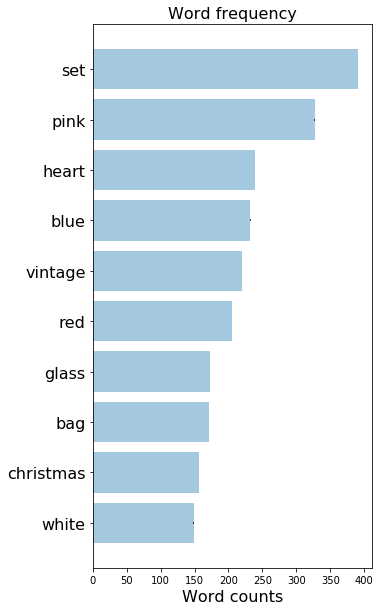

In [115]:
keys = [val[0] for val in sorted_counts]
y_pos = np.arange(len(sorted_counts))
performance = [val[1] for val in sorted_counts]
error = np.random.rand(len(keys))

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
ax.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
#plt.subplots(figsize=(20, 10))

plt.yticks(y_pos, keys,fontsize=16)
plt.xlabel('Word counts', fontsize=16)
plt.title('Word frequency', fontsize=16)

plt.show()